In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

In [2]:
import utils

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Read data

In [4]:
metadata = pd.read_csv('../data/plasticc/plasticc_train_metadata.csv.gz')
data = pd.read_csv('../data/plasticc/plasticc_train_lightcurves.csv.gz')

data = data[data.detected_bool == 1]

In [5]:
metadata.head()

object_id        ra     decl  ddf_bool  hostgal_specz  hostgal_photoz  \
0        615  349.0461 -61.9438         1          0.000           0.000   
1        713   53.0859 -27.7844         1          1.818           1.627   
2        730   33.5742  -6.5796         1          0.232           0.226   
3        745    0.1899 -45.5867         1          0.304           0.281   
4       1124  352.7113 -63.8237         1          0.193           0.241   

   hostgal_photoz_err  distmod  mwebv  target  ...  true_rv  true_av  \
0               0.000   -9.000  0.017      92  ...      0.0      0.0   
1               0.255   45.406  0.007      88  ...      0.0      0.0   
2               0.016   40.256  0.021      42  ...      0.0      0.0   
3               1.152   40.795  0.007      90  ...      0.0      0.0   
4               0.018   40.417  0.024      90  ...      0.0      0.0   

   true_peakmjd  libid_cadence  tflux_u  tflux_g  tflux_r  tflux_i  tflux_z  \
0     59570.000             69    484.7   3286.7   3214.1   3039.7   2854.5   
1     59570.000             34    108.7    117.7    119.9    149.6    147.9   
2     60444.379              9      0.0      0.0      0.0      0.0      0.0   
3     60130.453             38      0.0      0.0      0.0      0.0      0.0   
4     60452.641              1      0.0      0.0      0.0      0.0      0.0   

   tflux_y  
0   2837.0  
1    150.5  
2      0.0  
3      0.0  
4      0.0  

[5 rows x 26 columns]

In [6]:
data.head()

object_id         mjd  passband        flux   flux_err  detected_bool
0        615  59750.4229         2 -544.810303   3.622952              1
1        615  59750.4306         1 -816.434326   5.553370              1
2        615  59750.4383         3 -471.385529   3.801213              1
3        615  59750.4450         4 -388.984985  11.395031              1
4        615  59752.4070         2 -681.858887   4.041204              1

In [7]:
object_ids = np.unique(data.object_id)

In [8]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

# Visual analysis

In [9]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id]
    return anobject

In [10]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [11]:
def add_log_lam(anobject):
    passbands = anobject.passband.values
    log_lam = [passband2lam[i] for i in passbands]
    anobject['log_lam'] = log_lam
    return anobject

In [12]:
def create_approx_object(anobject, n=1000):
    mjd = anobject['mjd'].values
    dfs = []
    for passband in range(6):
        df = pd.DataFrame()
        df['mjd'] = np.linspace(mjd.min(), mjd.max(), n)
        df['object_id'] = 0
        df['passband'] = passband
        df['flux'] = 0
        df['flux_err'] = 0
        df['detected_bool'] = 1
        dfs.append(df)
    new_object = pd.concat(dfs, axis=0)
    new_object = add_log_lam(new_object)
    return new_object

In [13]:
def is_good(anobject):
    good = 1
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        good = 0
    
    # keep only objects with at least 10 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 10:
            count += 1
    if count > 3:
        good = 0
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        good = 0
    
    return good

In [14]:
def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)

In [15]:
def plot_light_curves_with_sigma(anobject, anobject_real, title=""):
    anobject = anobject.sort_values('mjd')
    colors = ['C'+str(i) for i in range(6)]
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        light_curve_real = get_passband(anobject_real, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=2., color=colors[passband])
        plt.fill_between(light_curve['mjd'].values, 
                         light_curve['flux'].values+3*light_curve['flux_err'].values, 
                         light_curve['flux'].values-3*light_curve['flux_err'].values, label=passband2name[passband], alpha=0.5, color=colors[passband])
        plt.scatter(light_curve_real['mjd'].values, light_curve_real['flux'].values, linewidth=1, color=colors[passband])
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)

34299


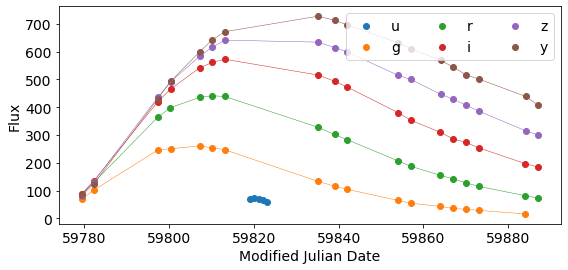

43812


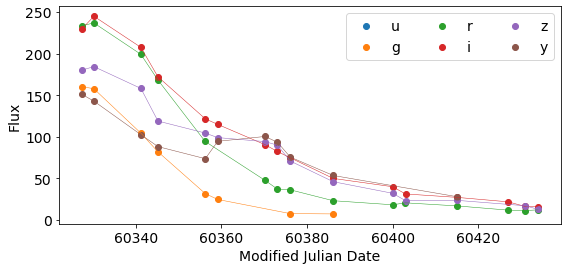

70046


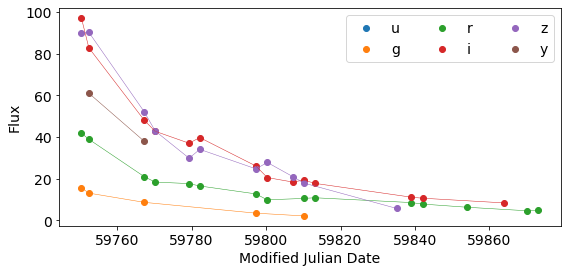

84716


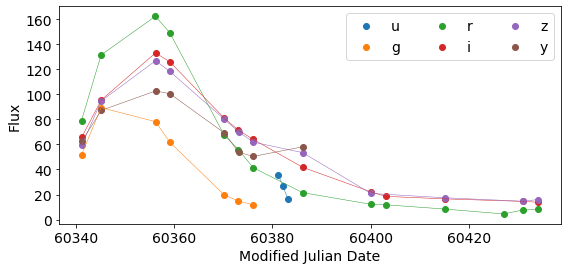

131629


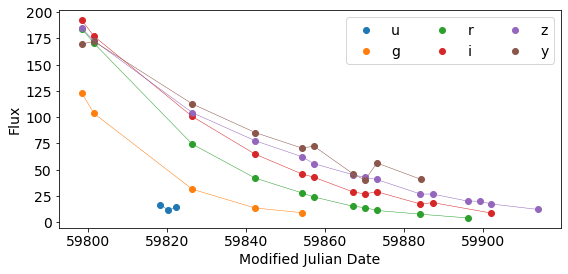

169315


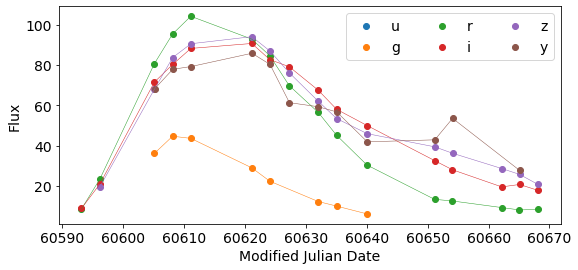

229855


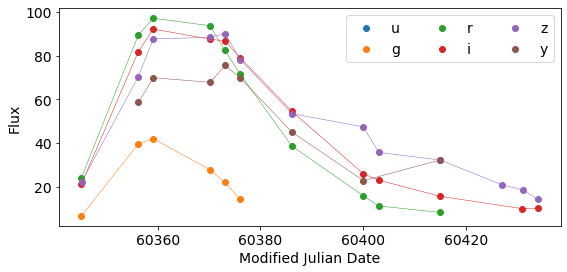

251430


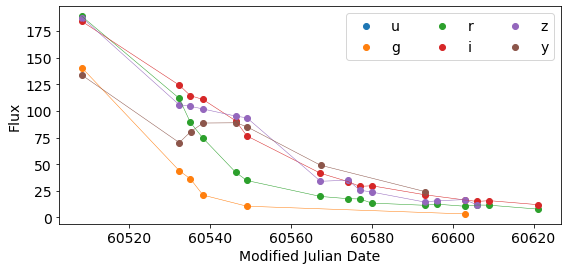

282714


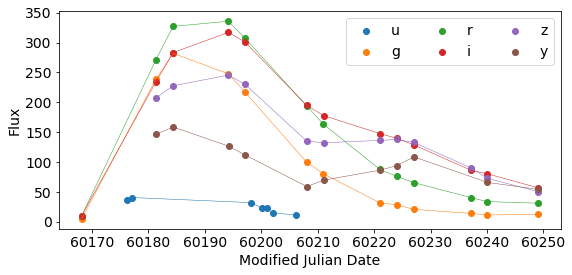

290682


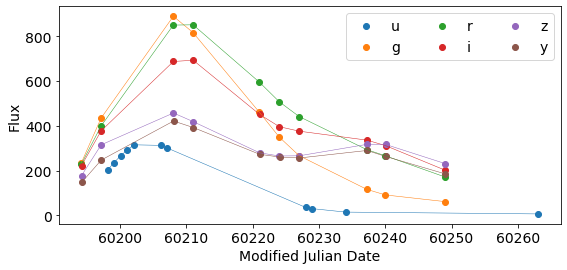

316306


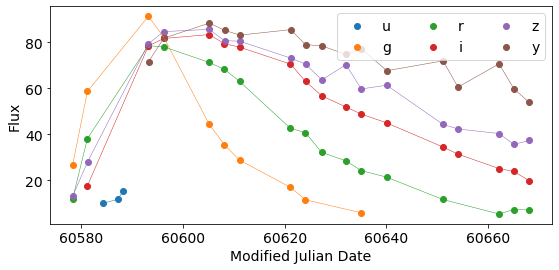

In [16]:
for i in object_ids[::50]:
    anobject = get_object(data, i)
    
    if not is_good(anobject): continue
    print(i)
    
    plot_light_curves(anobject)
    plt.show()

# NF

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device('cpu')
DEVICE

device(type='cpu')

# One object test Test

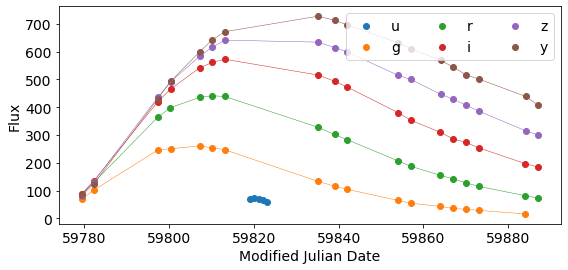

In [18]:
anobject = get_object(data, 34299) # 198103 34299
anobject = add_log_lam(anobject)

plot_light_curves(anobject)
# plt.savefig('light_curve_34299.pdf', format='pdf')

In [19]:
MODEL = "NF"

In [20]:
from nf_aug import NFFitter

In [21]:
%%time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, WhiteKernel, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)

X_train = anobject_train[['mjd', 'log_lam']].values
X_test = anobject_test[['mjd', 'log_lam']].values

y_train = anobject_train['flux'].values
y_train_std = anobject_train['flux_err'].values
y_test  = anobject_test['flux'].values

ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

# fit a regression model to approximate light curves
if MODEL == "NF":   
    reg = NFFitter(var_size=2, cond_size=2, normalize_y=True, batch_size=500, n_epochs=3000, lr=0.005, randomize_x=True)
    reg.fit(X_train_ss, y_train, y_train_std)
elif MODEL == "GP":
    kernel = C(1.0) * RBF([1.0, 1.0]) + WhiteKernel()
    reg = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=5, optimizer="fmin_l_bfgs_b", random_state=42)
    reg.fit(X_train_ss, y_train)

# predict flux for unseen observations
anobject_test_pred = anobject_test.copy()
anobject_test_pred['flux'] = reg.predict(X_test_ss)
if MODEL == "NF":
    anobject_test_pred['flux'], anobject_test_pred['flux_err'] = reg.predict_n_times(X_test_ss, n_times=100)
elif MODEL == "GP":
    anobject_test_pred['flux'], anobject_test_pred['flux_err'] = reg.predict(X_test_ss, return_std=True)

CPU times: user 25 s, sys: 16 ms, total: 25 s
Wall time: 25 s


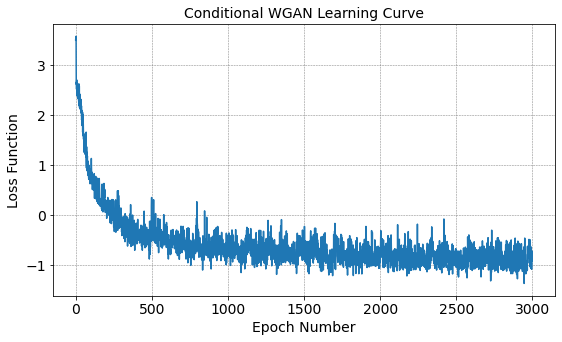

In [22]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(reg.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
plt.show()

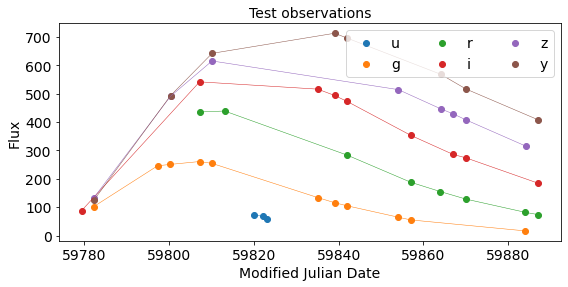

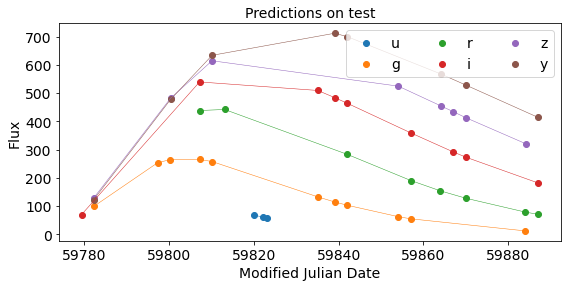

In [23]:
plot_light_curves(anobject_test, "Test observations")
plot_light_curves(anobject_test_pred, "Predictions on test")

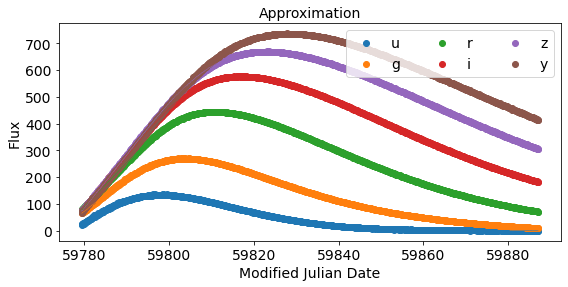

In [24]:
approx_object = create_approx_object(anobject)
X = approx_object[['mjd', 'log_lam']].values
X_ss = ss.transform(X)
if MODEL == "NF":
    approx_object['flux'], approx_object['flux_err'] = reg.predict_n_times(X_ss, n_times=100)
elif MODEL == "GP":
    approx_object['flux'], approx_object['flux_err'] = reg.predict(X_ss, return_std=True)
plot_light_curves(approx_object, "Approximation")
# plt.savefig('approx_light_curve_34299.pdf', format='pdf')

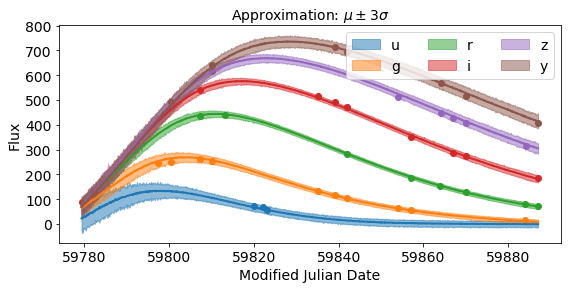

In [25]:
approx_object = create_approx_object(anobject)
X = approx_object[['mjd', 'log_lam']].values
X_ss = ss.transform(X)
if MODEL == "NF":
    approx_object['flux'], approx_object['flux_err'] = reg.predict_n_times(X_ss, n_times=100)
elif MODEL == "GP":
    approx_object['flux'], approx_object['flux_err'] = reg.predict(X_ss, return_std=True)
plot_light_curves_with_sigma(approx_object, anobject_test, "Approximation: " + r"$\mu \pm 3\sigma$")
# plt.savefig('approx_light_curve_34299.pdf', format='pdf')

In [26]:
# calculate quality metrics
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                                      anobject_test_pred['flux'].values)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)

RMSE:  6.397837299532838
MAE:  4.928810574399255
RSE:  0.03229277047912882
RAE:  0.02814631852406237
MAPE:  2.8963790747105267


# Test on many objects

In [27]:
from joblib import Parallel, delayed

In [28]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler

def one_object_run(i):
    
    # get an object
    anobject = get_object(data, i)
    anobject = add_log_lam(anobject)
    
    if not is_good(anobject): 
        return None
    
    # print("Object ", i, " with ", len(anobject), " observations")
    
    # train / test split
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.2, random_state=11)
    
    X_train = anobject_train[['mjd', 'log_lam']].values
    X_test  = anobject_test[['mjd', 'log_lam']].values

    y_train = anobject_train['flux'].values
    y_train_std = anobject_train['flux_err'].values
    y_test  = anobject_test['flux'].values

    ss = StandardScaler()
    X_train_ss = ss.fit_transform(X_train)
    X_test_ss = ss.transform(X_test)

    # fit a regression model to approximate light curves
    if MODEL == "old_NF":  # i. e. no randomized X and y_std
        reg = NFFitter(var_size=2, cond_size=2, normalize_y=True, batch_size=500, n_epochs=3000, lr=0.005, randomize_x=False)
        reg.fit(X_train_ss, y_train)  
    elif MODEL == "NF":   
        reg = NFFitter(var_size=2, cond_size=2, normalize_y=True, batch_size=500, n_epochs=3000, lr=0.005, randomize_x=True)
        reg.fit(X_train_ss, y_train, y_train_std)
    elif MODEL == "GP":
        kernel = C(1.0) * RBF([1.0, 1.0]) + WhiteKernel()
        reg = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=5, optimizer="fmin_l_bfgs_b", random_state=42)
        reg.fit(X_train_ss, y_train)

    
    # predict flux for unseen observations
    anobject_test_pred = anobject_test.copy()
    #anobject_test_pred['flux'] = reg.predict(X_test_ss)
    if MODEL == "old_NF":
        anobject_test_pred['flux'], anobject_test_pred['flux_err'] = reg.predict_n_times(X_test_ss, n_times=100)
    elif MODEL == "NF":
        anobject_test_pred['flux'], anobject_test_pred['flux_err'] = reg.predict_n_times(X_test_ss, n_times=100)
    elif MODEL == "GP":
        anobject_test_pred['flux'], anobject_test_pred['flux_err'] = reg.predict(X_test_ss, return_std=True)
    
    metrics = utils.regression_quality_metrics_report(anobject_test['flux'].values, anobject_test_pred['flux'].values)
    
    return [i] + list(metrics)

In [29]:
import tqdm

In [30]:
def gen_report(metrics):
    report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])
    for i, met in enumerate(metrics):
        if met is not None:
            report.loc[len(report), :] = list(met)
    return report

In [31]:
%%time

MODEL = "GP"
metrics  = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in tqdm.notebook.tqdm(object_ids))
report_gp = gen_report(metrics)


CPU times: user 6.59 s, sys: 378 ms, total: 6.97 s
Wall time: 48 s


In [32]:
%%time

MODEL = "old_NF"
metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in tqdm.notebook.tqdm(object_ids))
report_old_nf = gen_report(metrics)


CPU times: user 11.9 s, sys: 606 ms, total: 12.5 s
Wall time: 52min 46s


In [33]:
%%time

MODEL = "NF"
metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in tqdm.notebook.tqdm(object_ids))
report_nf = gen_report(metrics)


CPU times: user 11.8 s, sys: 580 ms, total: 12.4 s
Wall time: 46min 25s


In [34]:
print("Metrics for GP:")
np.round(report_gp.mean(), 2)

Metrics for GP:


ID      340898.23
RMSE        24.65
MAE         12.27
RSE          0.16
RAE          0.14
MAPE        16.56
dtype: float64

In [35]:
print("Metrics for old NF:")
np.round(report_old_nf.mean(), 2)

Metrics for old NF:


ID      340898.23
RMSE        16.05
MAE          8.66
RSE          0.19
RAE          0.15
MAPE        13.75
dtype: float64

In [36]:
print("Metrics for NF:")
np.round(report_nf.mean(), 2)

Metrics for NF:


ID      340898.23
RMSE        17.18
MAE          8.79
RSE          0.19
RAE          0.14
MAPE        13.11
dtype: float64

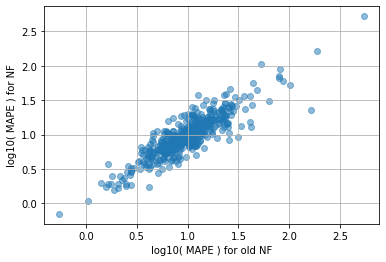

In [37]:
plt.scatter(np.log10(report_old_nf['MAPE'].values.astype(np.float)), 
            np.log10(report_nf['MAPE'].values.astype(np.float)), alpha=0.5)
plt.xlabel("log10( MAPE ) for old NF")
plt.ylabel("log10( MAPE ) for NF")
plt.grid(b=1)
plt.show()

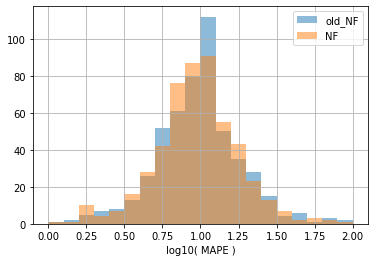

In [38]:
bins = np.linspace(0, 2, 21)
plt.hist(np.log10(report_old_nf['MAPE'].values.astype(np.float)), bins=bins, alpha=0.5, label='old_NF')
plt.hist(np.log10(report_nf['MAPE'].values.astype(np.float)), bins=bins, alpha=0.5, label='NF')
plt.xlabel("log10( MAPE )")
plt.grid(b=1)
plt.legend()
plt.show()

In [39]:
from scipy.stats import wilcoxon

for metric in report_nf.columns[1:]:
    print(metric)
    print('Wilcoxon p-value:', wilcoxon(report_old_nf[metric], report_nf[metric])[1])
    print()

RMSE
Wilcoxon p-value: 0.007845333966677635

MAE
Wilcoxon p-value: 0.05043093692969392

RSE
Wilcoxon p-value: 0.004249319341206821

RAE
Wilcoxon p-value: 0.02073448559268678

MAPE
Wilcoxon p-value: 0.07510637373228726



In [40]:
def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)
    return (plt.gca().get_xlim(), plt.gca().get_ylim())

def plot_light_curves_compare_errors(orig_object, approx_objects, titles=None):
    if titles is None:
        titles = [""] * (1 + len(approx_objects))
    xlim, ylim = plot_light_curves(orig_object, titles[0])
    colors = ['C'+str(i) for i in range(len(approx_objects))]
    
    plt.figure(figsize=(20, 20))
    n_obj = len(approx_objects)
    for passband in range(6):
        plt.subplot(3, 2, passband+1)
        for idx, anobject in enumerate(approx_objects):
            anobject = anobject.sort_values('mjd')
            light_curve = get_passband(anobject, passband)
            light_curve_real = get_passband(orig_object, passband)
            plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=2., color=colors[idx])
            plt.fill_between(light_curve['mjd'].values, 
                             light_curve['flux'].values+3*light_curve['flux_err'].values, 
                             light_curve['flux'].values-3*light_curve['flux_err'].values,
                             label=titles[idx+1], alpha=0.2, color=colors[idx])
        plt.scatter(light_curve_real['mjd'].values, light_curve_real['flux'].values,
                    linewidth=1, color='black', label='True values')
#         plt.plot(light_curve_real['mjd'].values, light_curve_real['flux'].values, color='black')
        plt.xlabel('Modified Julian Date', size=14)
        plt.xticks(size=14)
        plt.ylabel('Flux', size=14)
        plt.yticks(size=14)
        plt.legend(loc='best', fontsize=14)
        plt.title(f'Passband {passband2name[passband]}', size=14)
        plt.xlim(*xlim)
        plt.ylim(*ylim)
    plt.show()

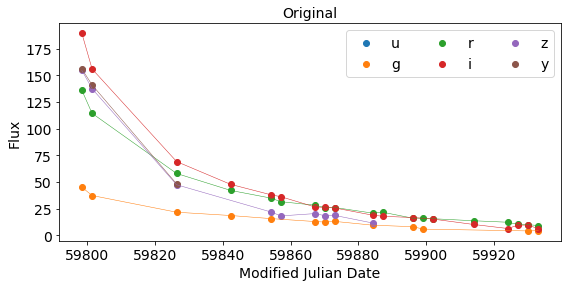

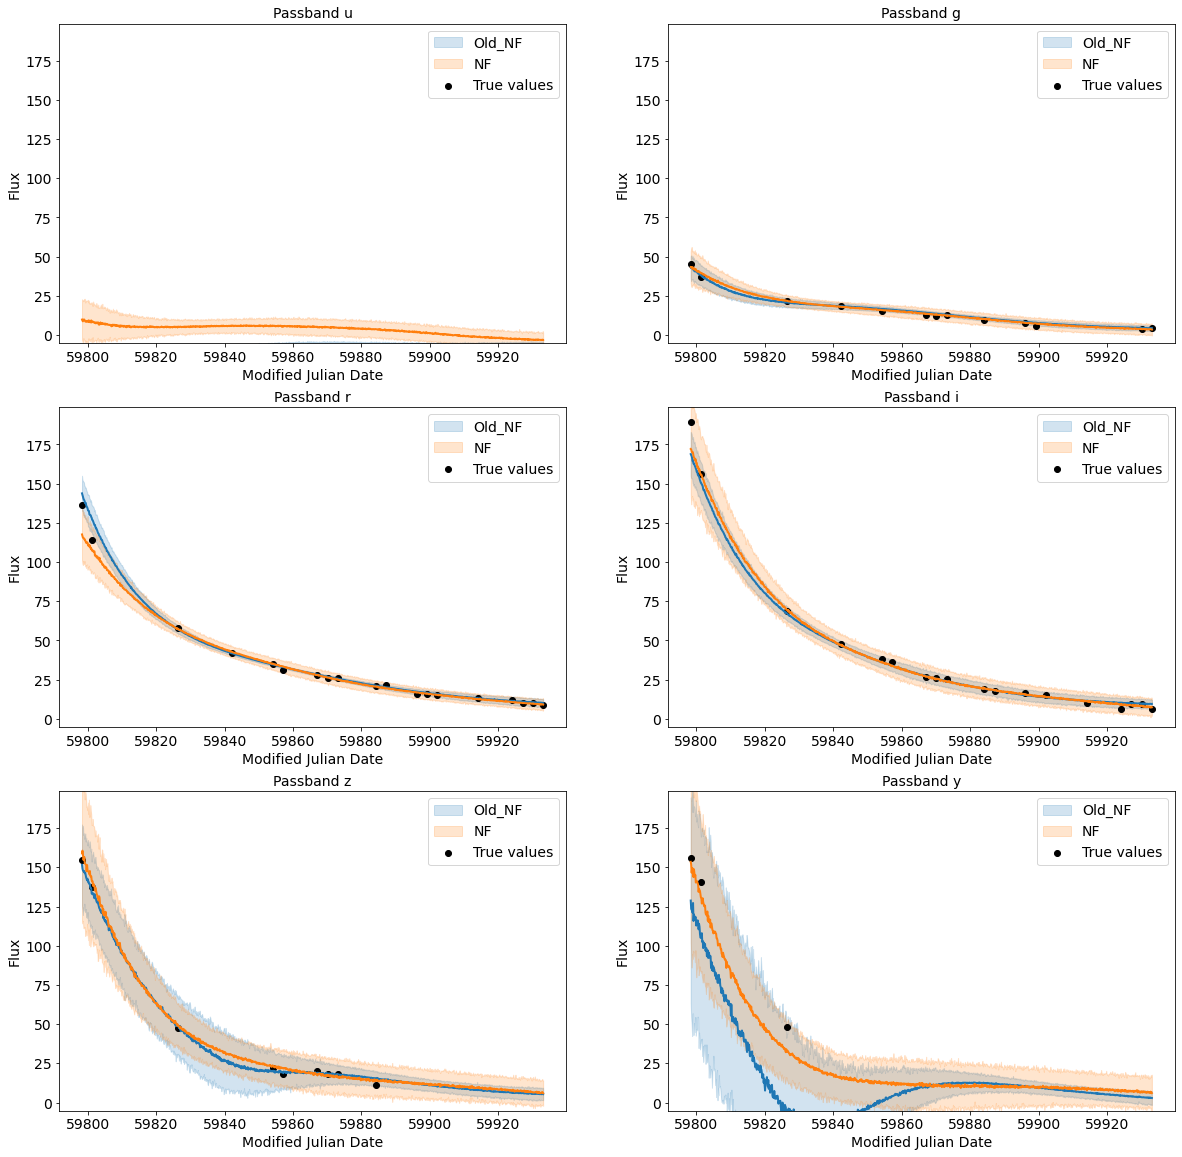

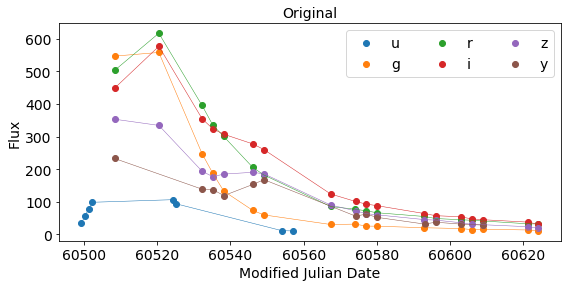

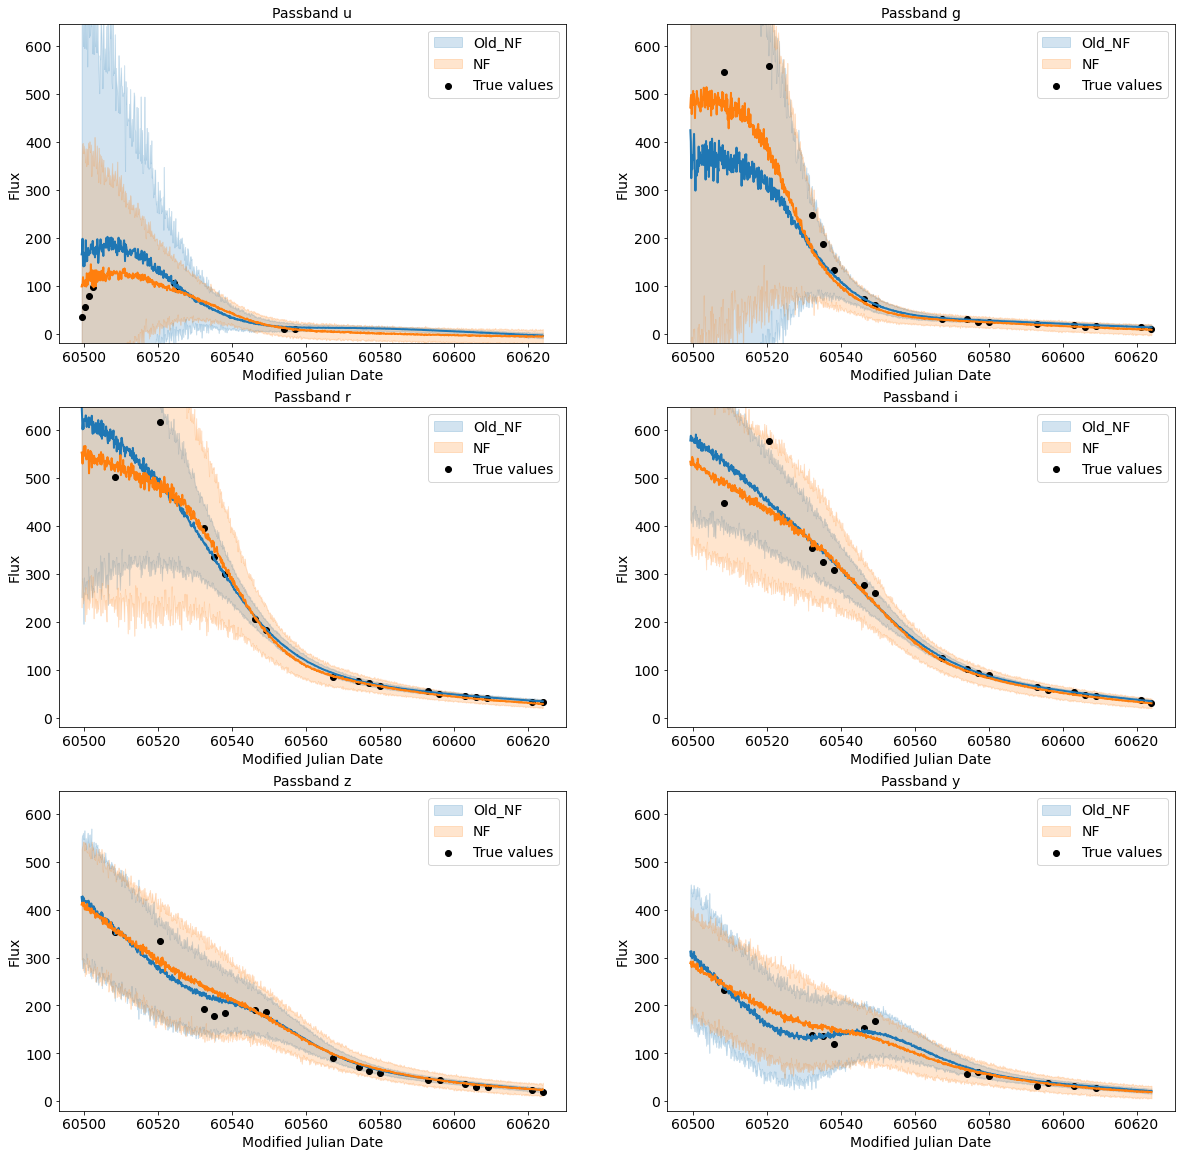

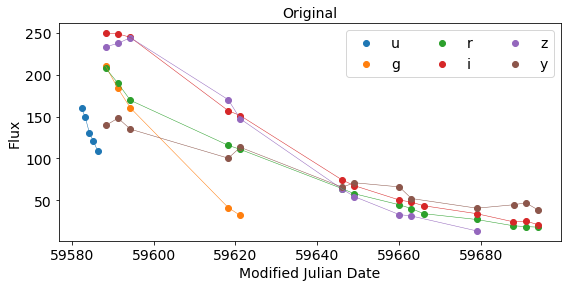

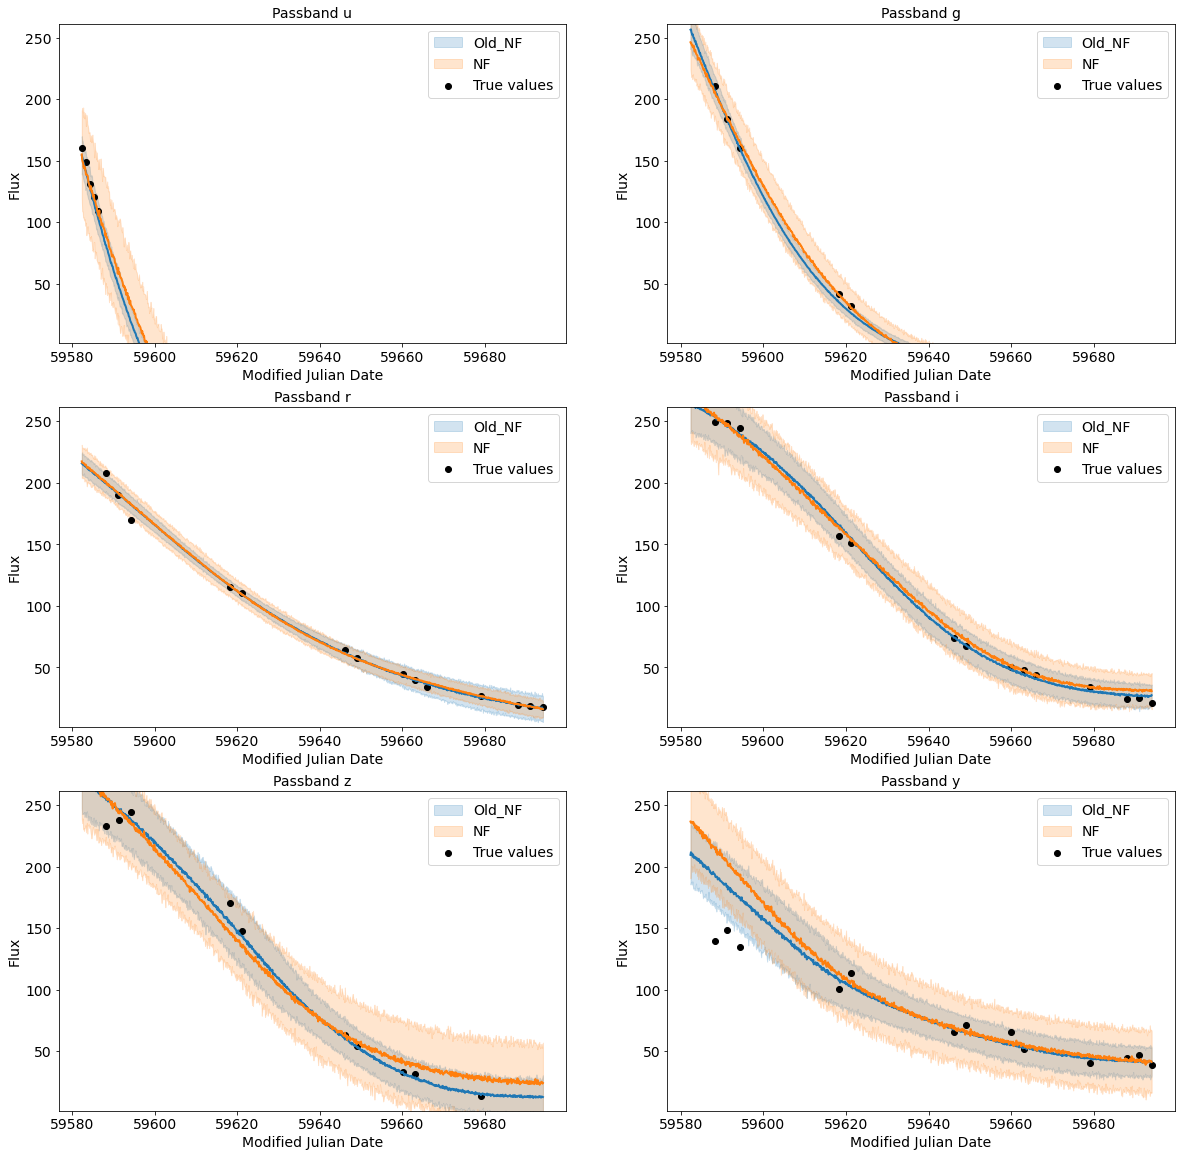

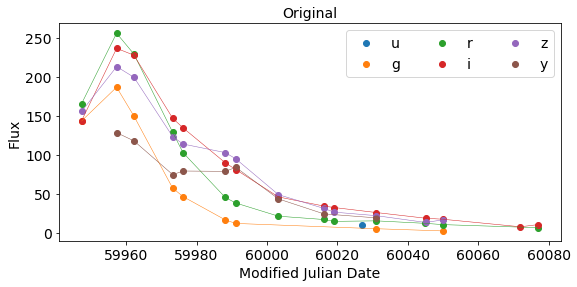

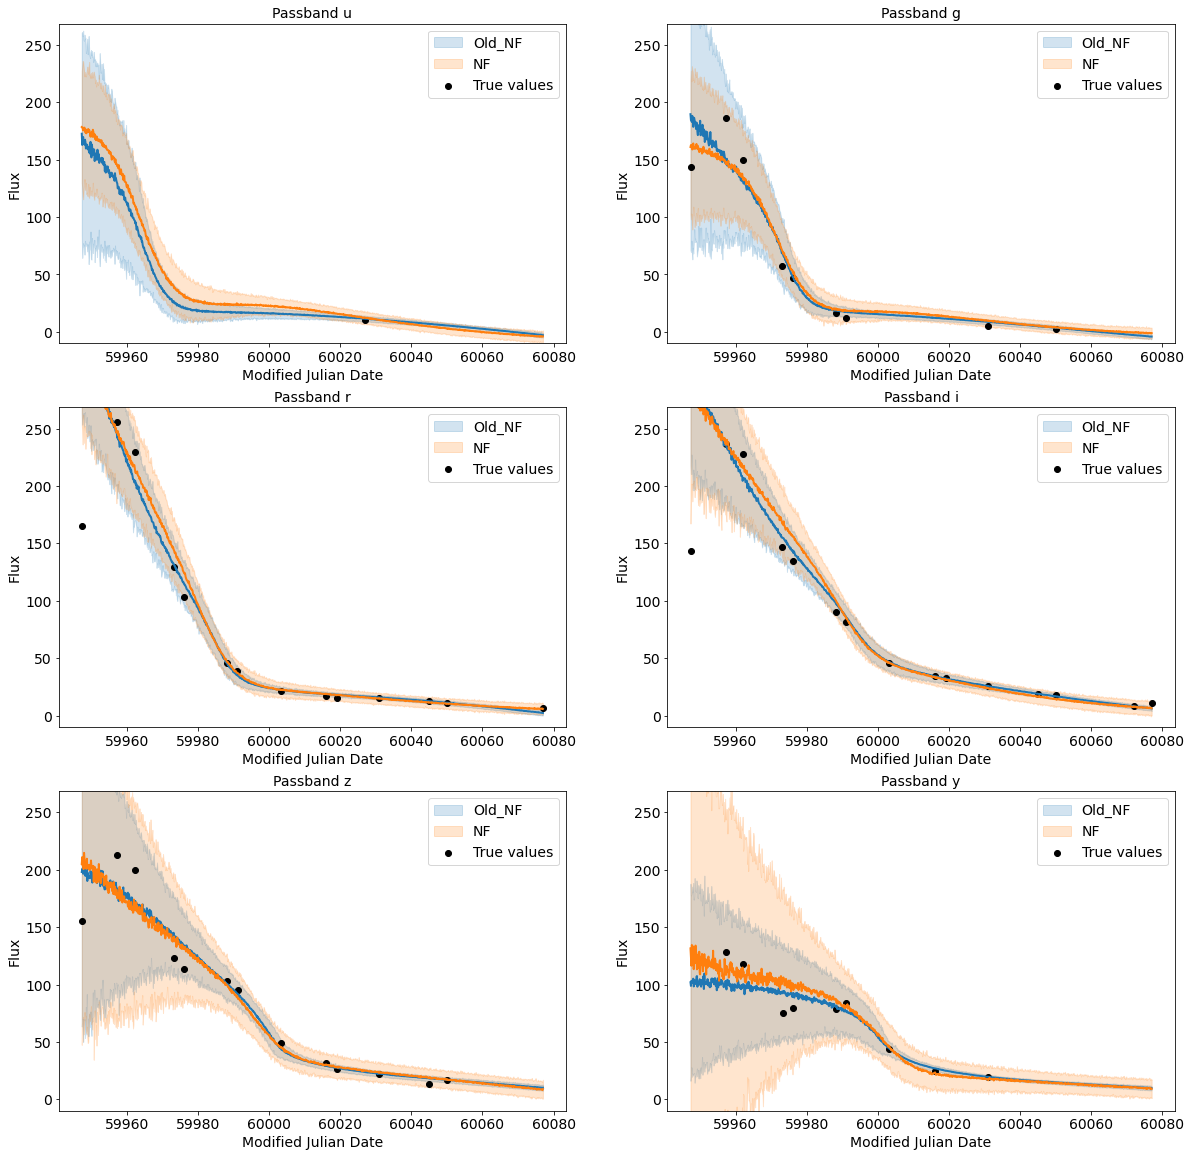

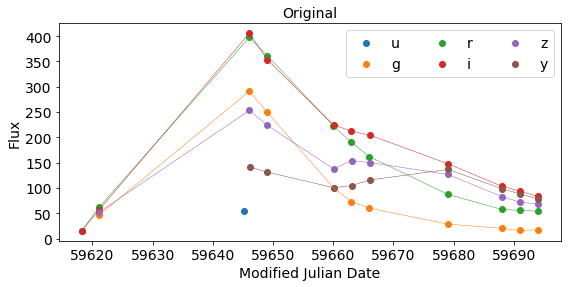

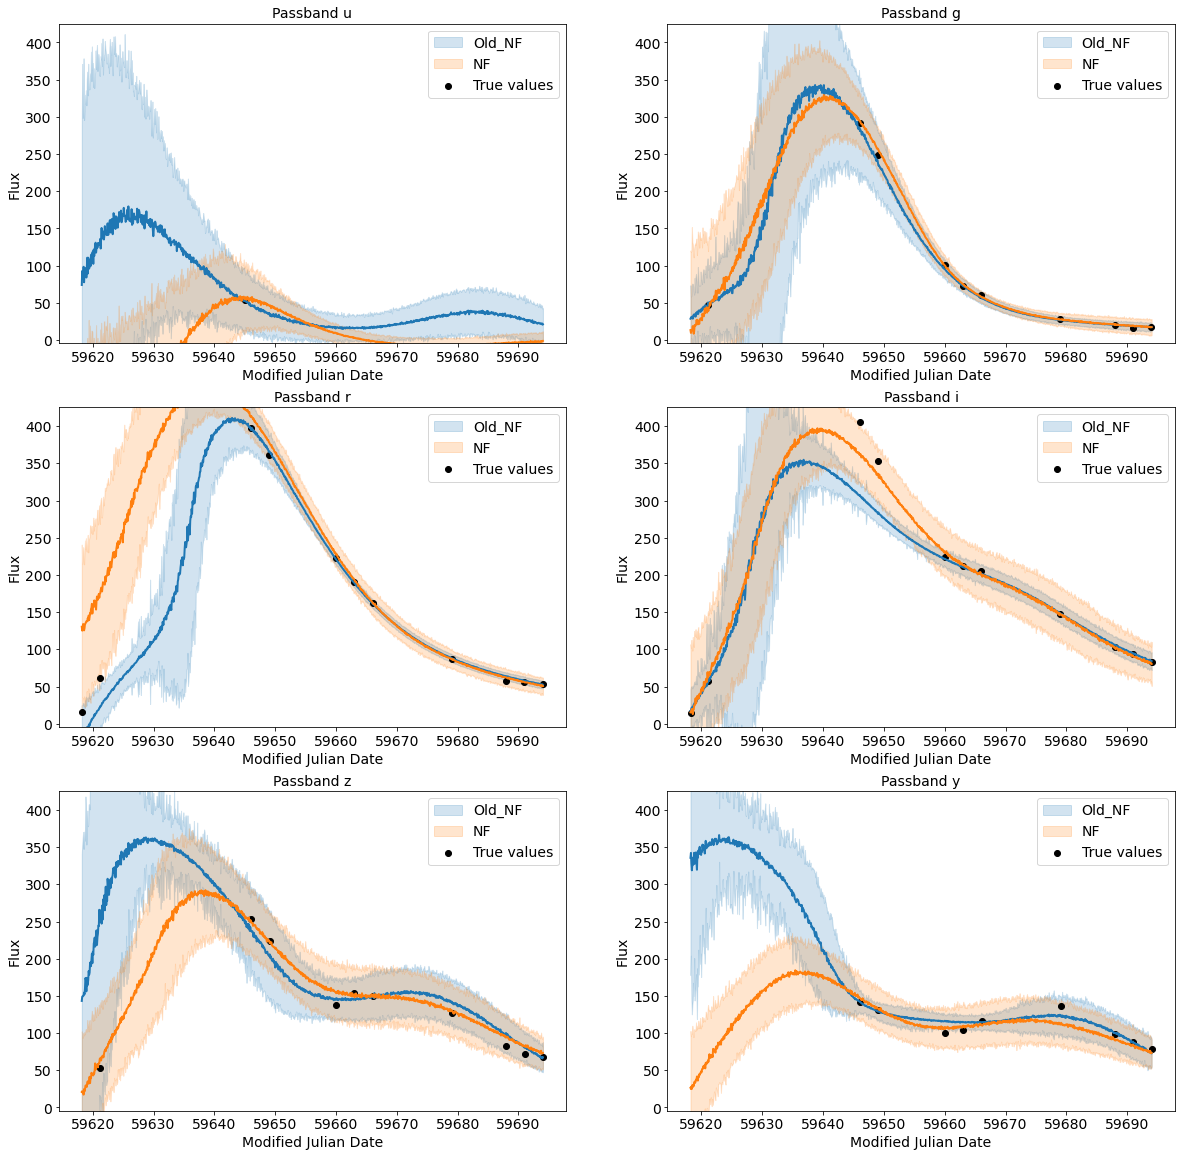

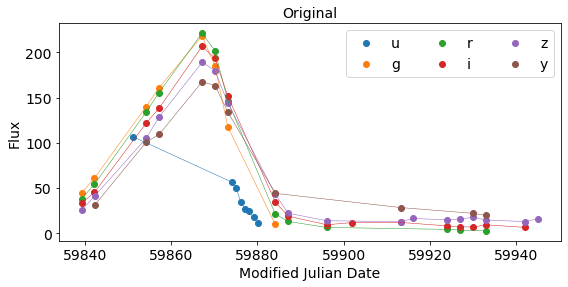

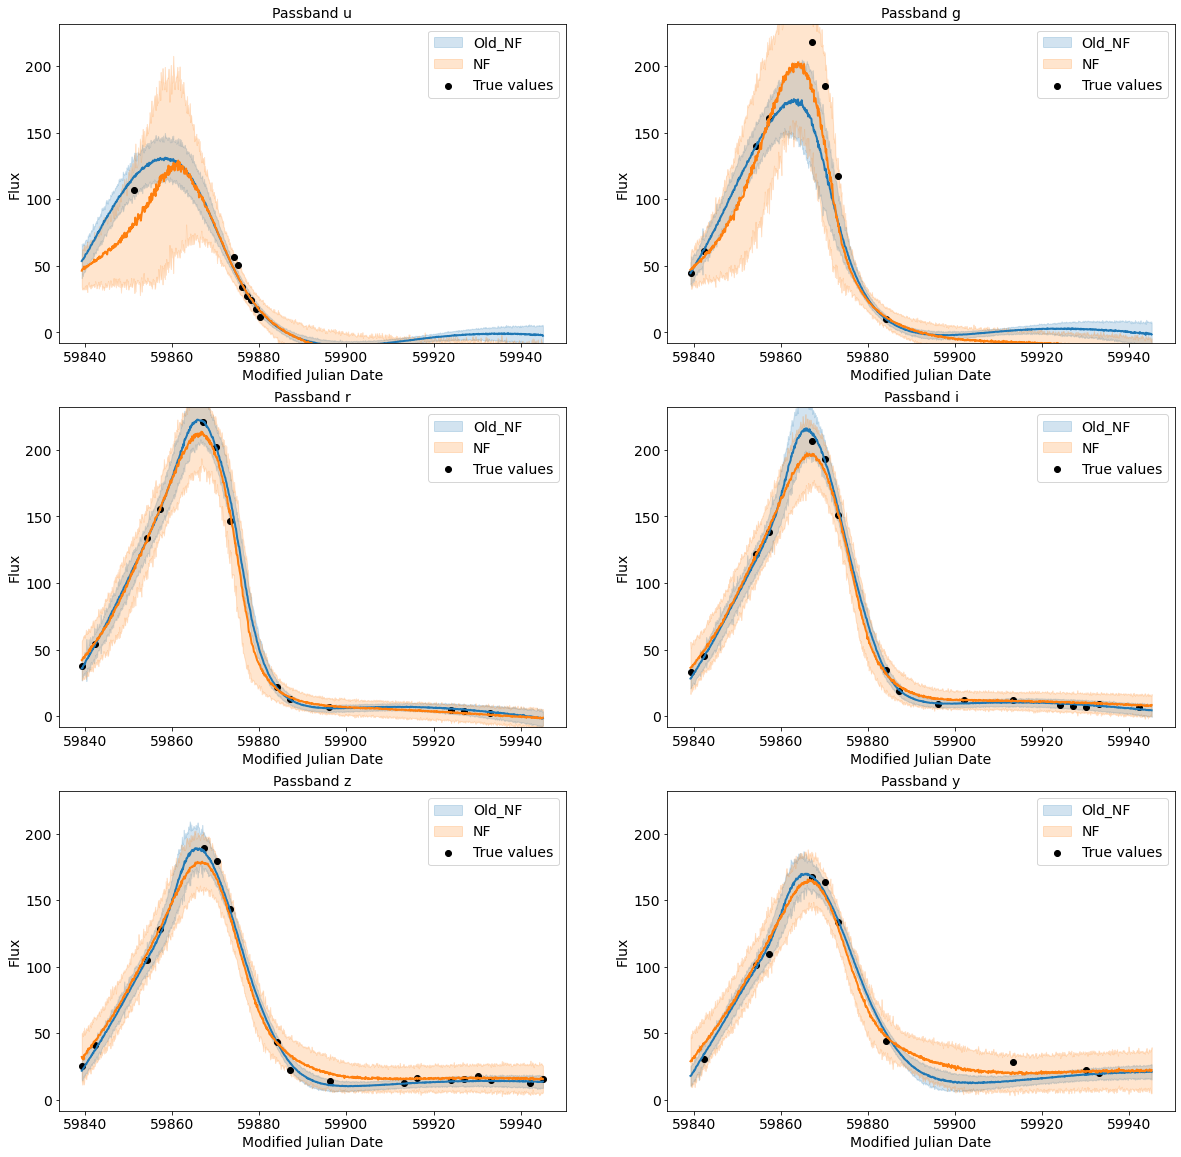

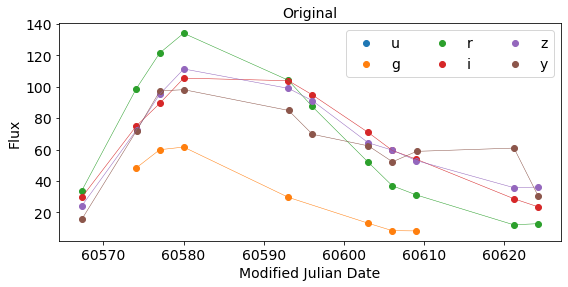

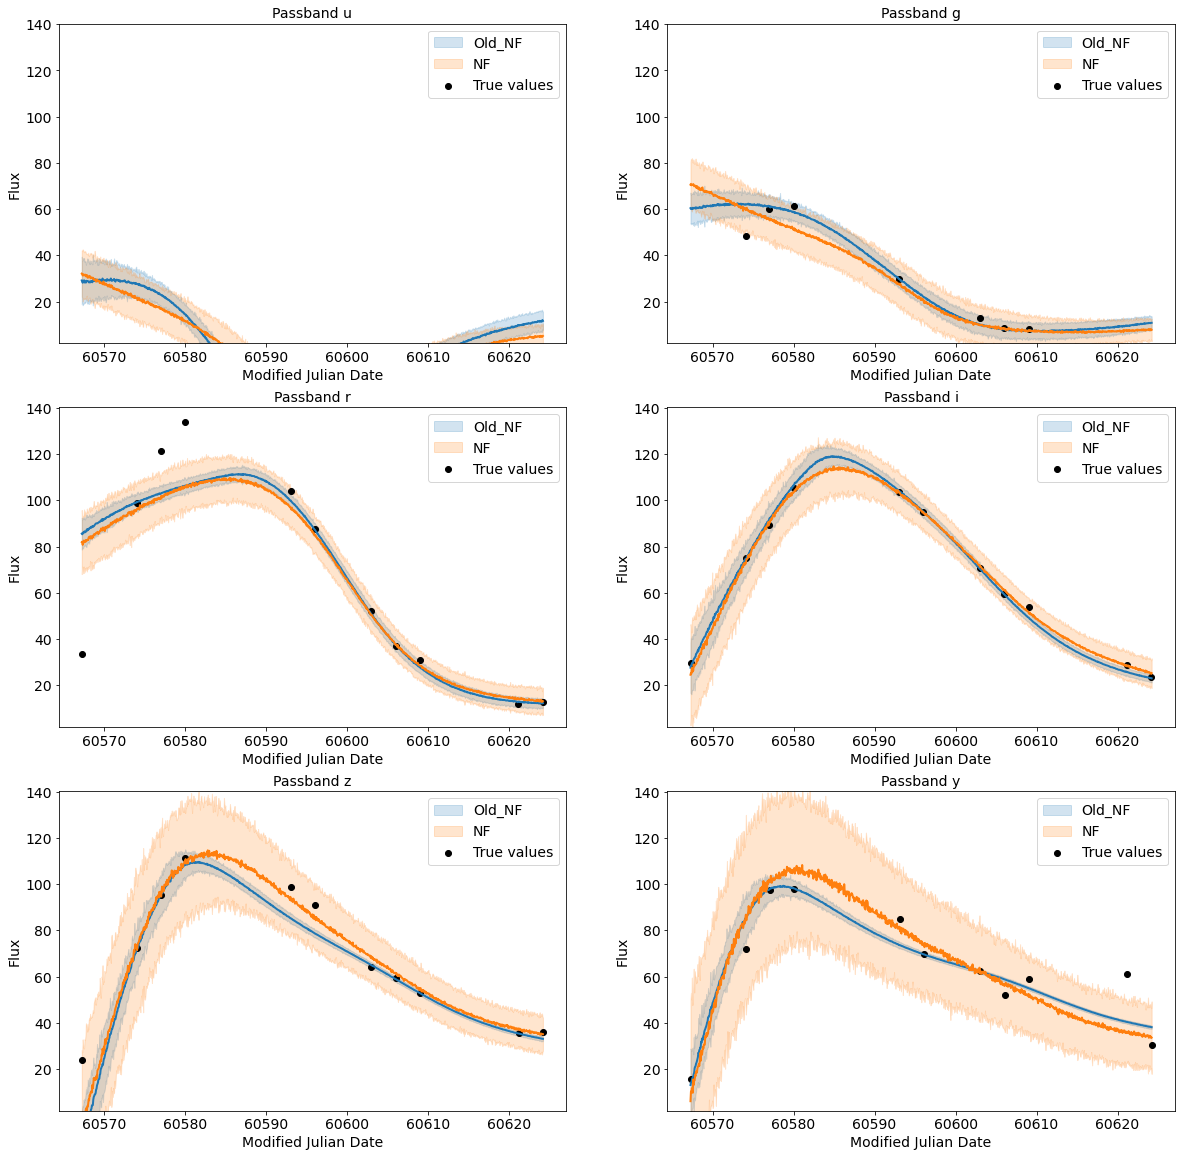

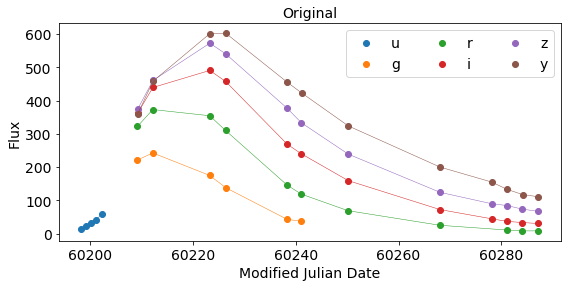

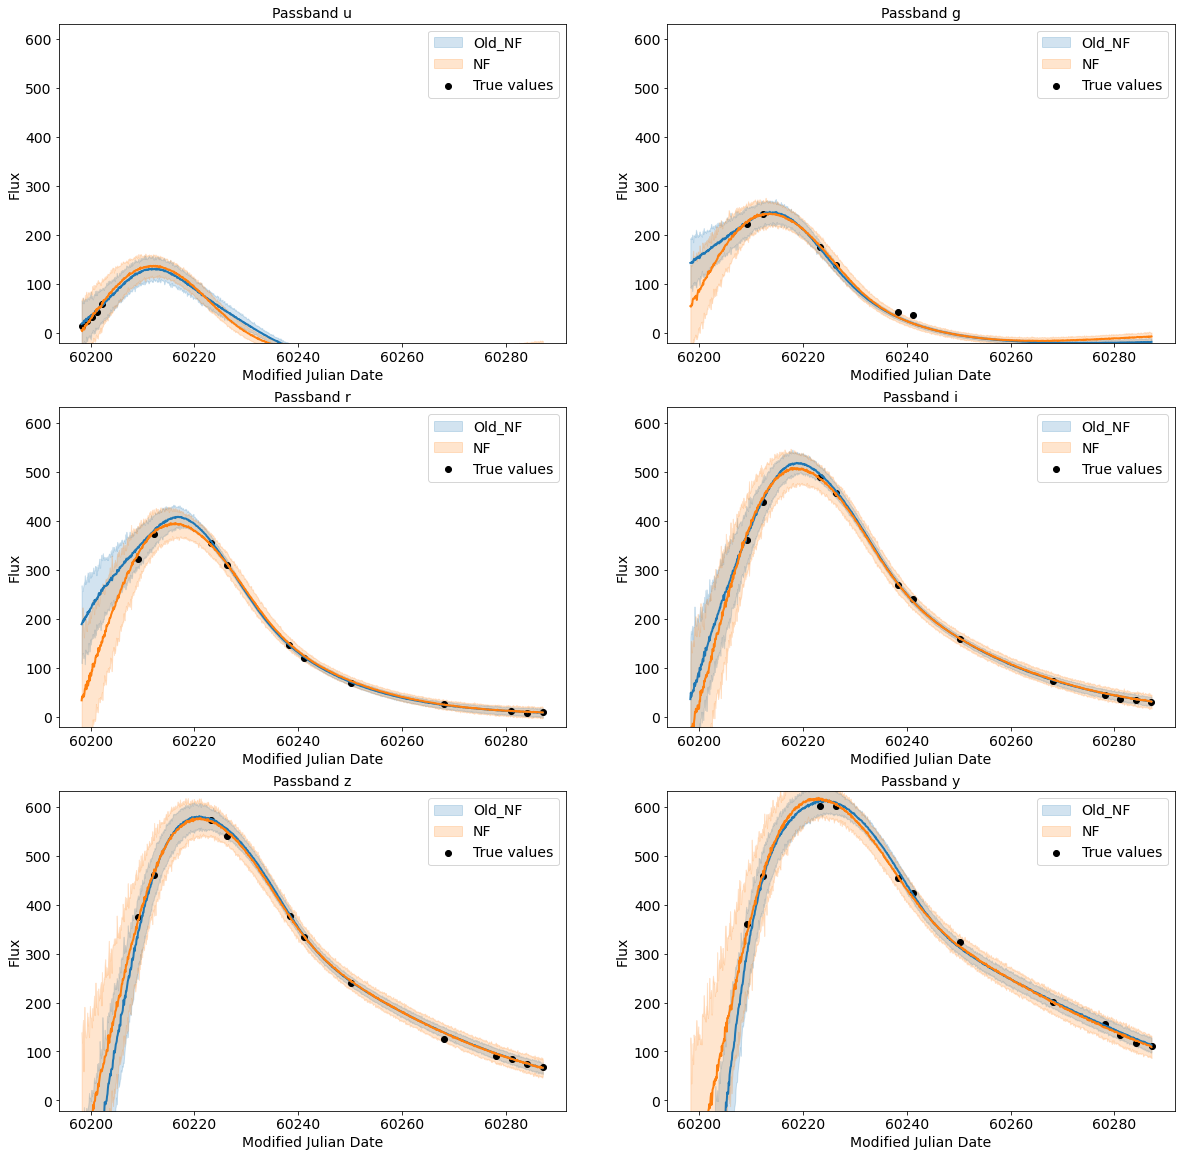

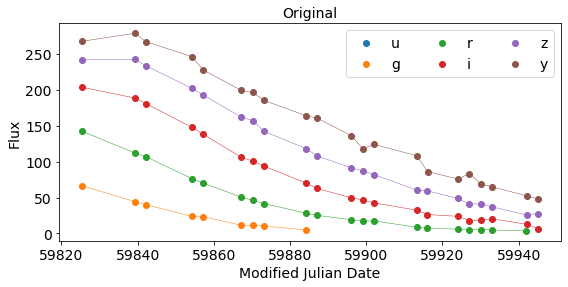

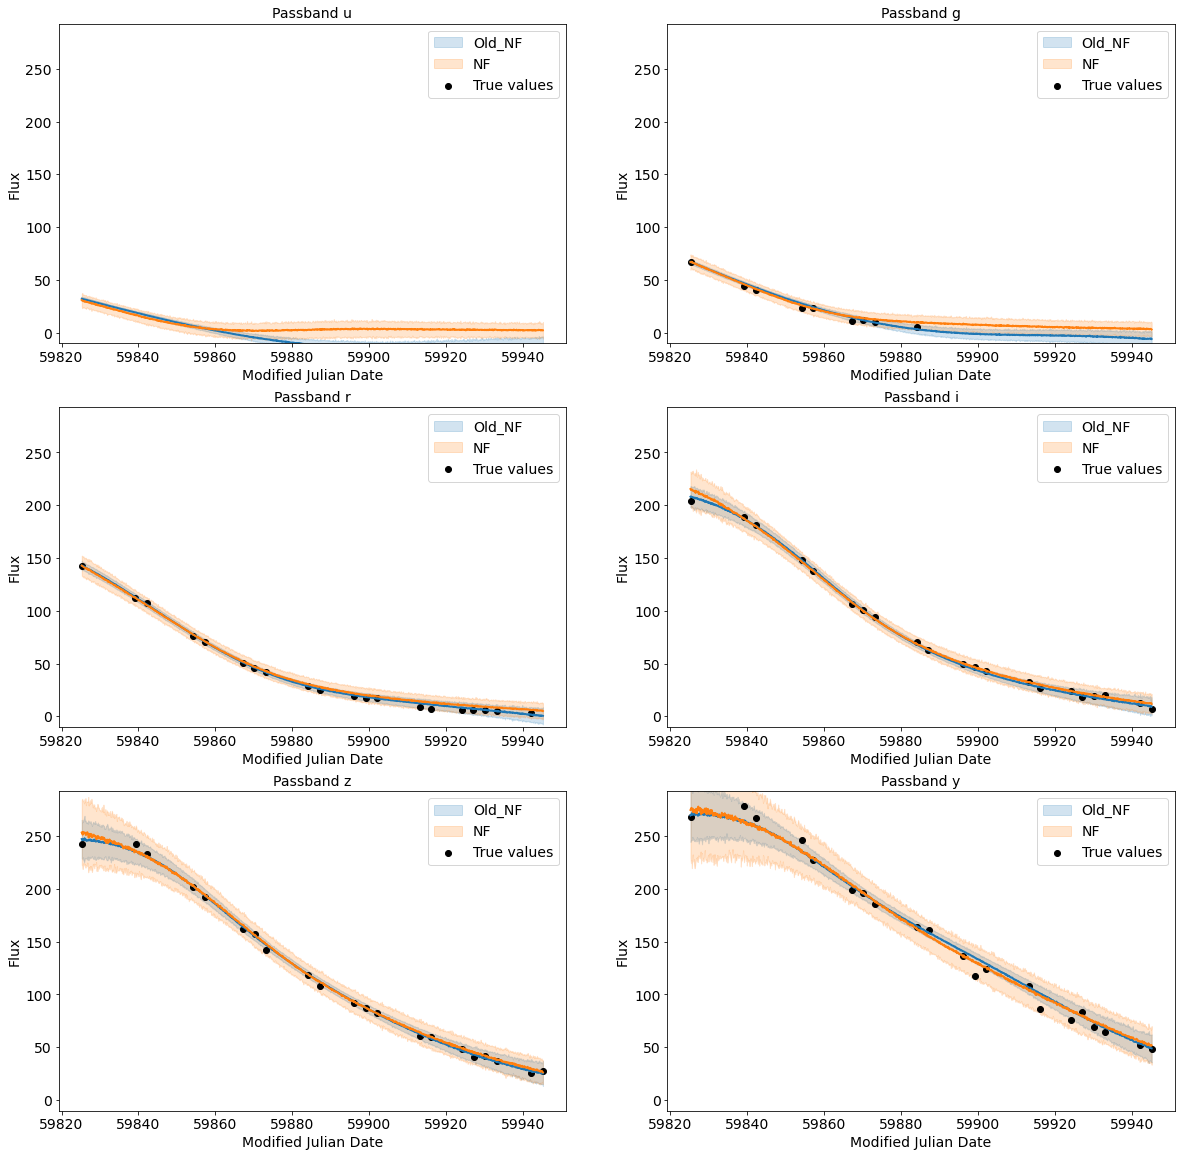

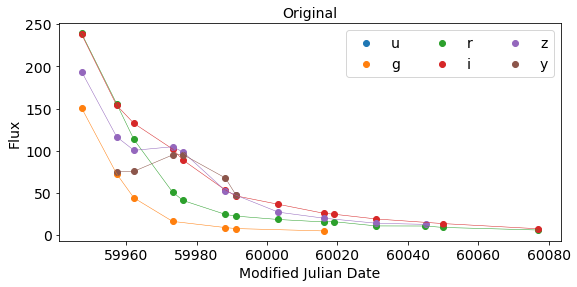

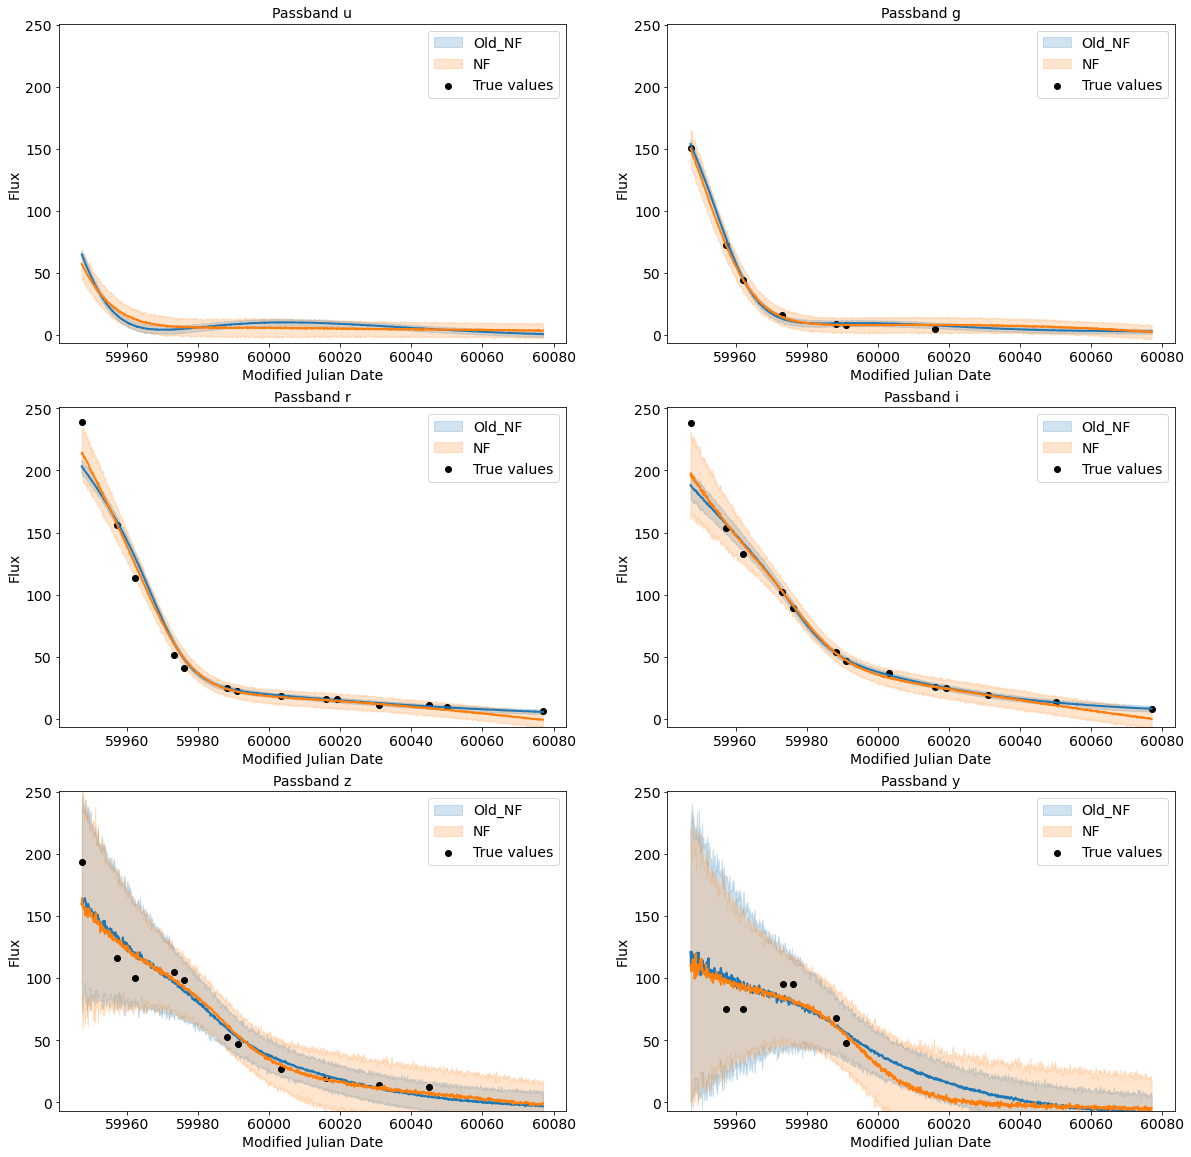

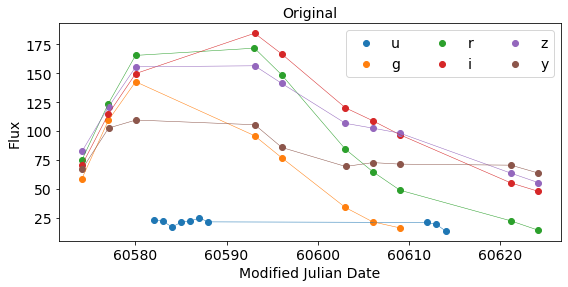

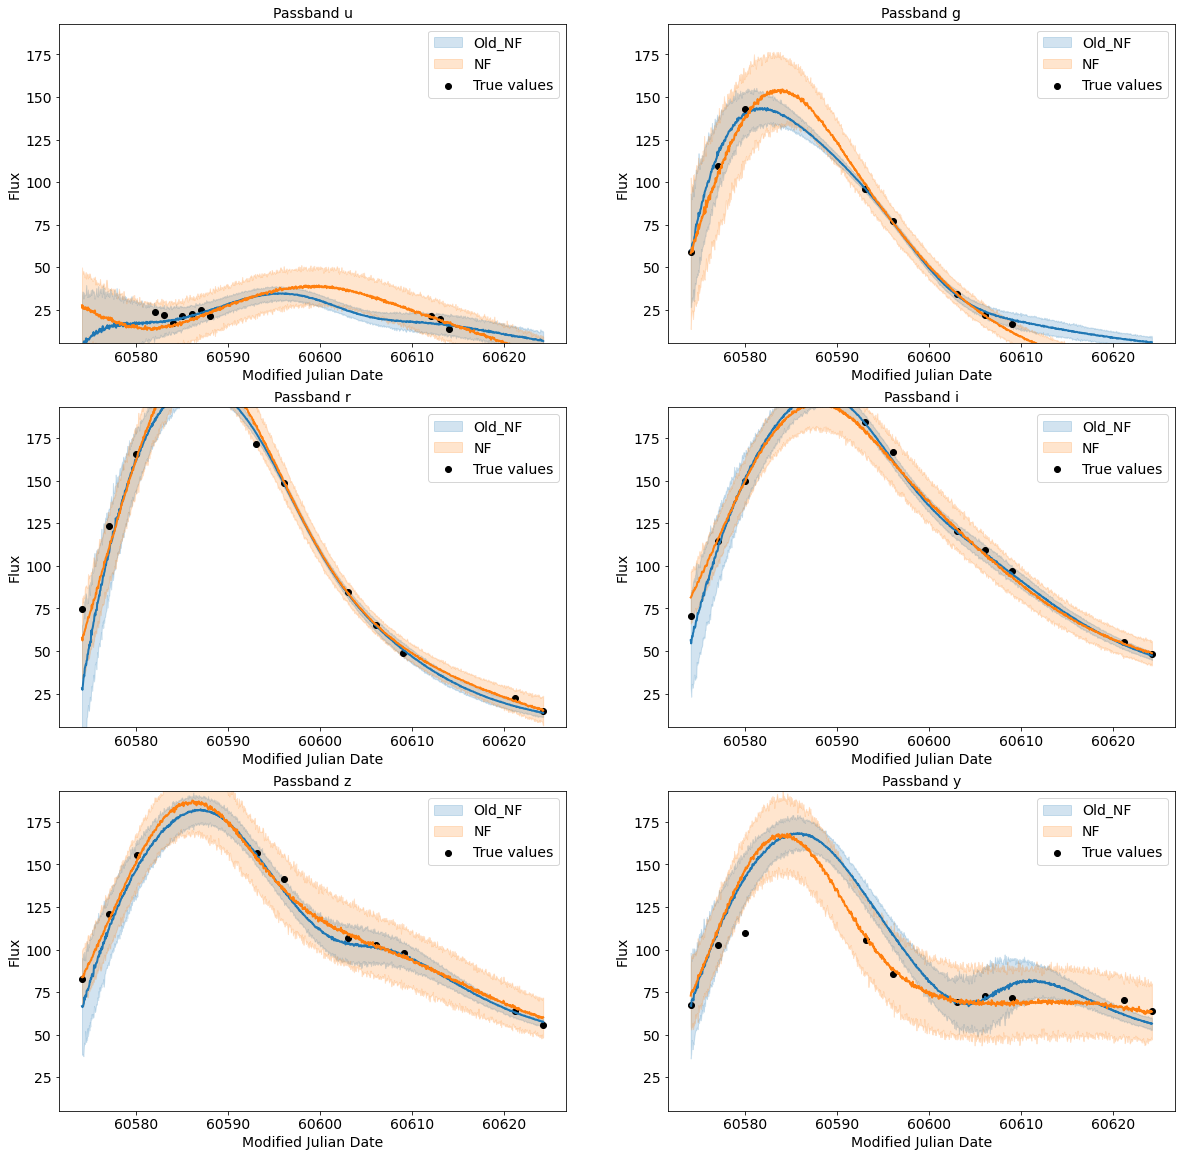

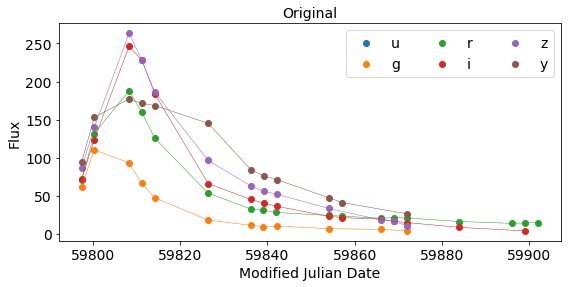

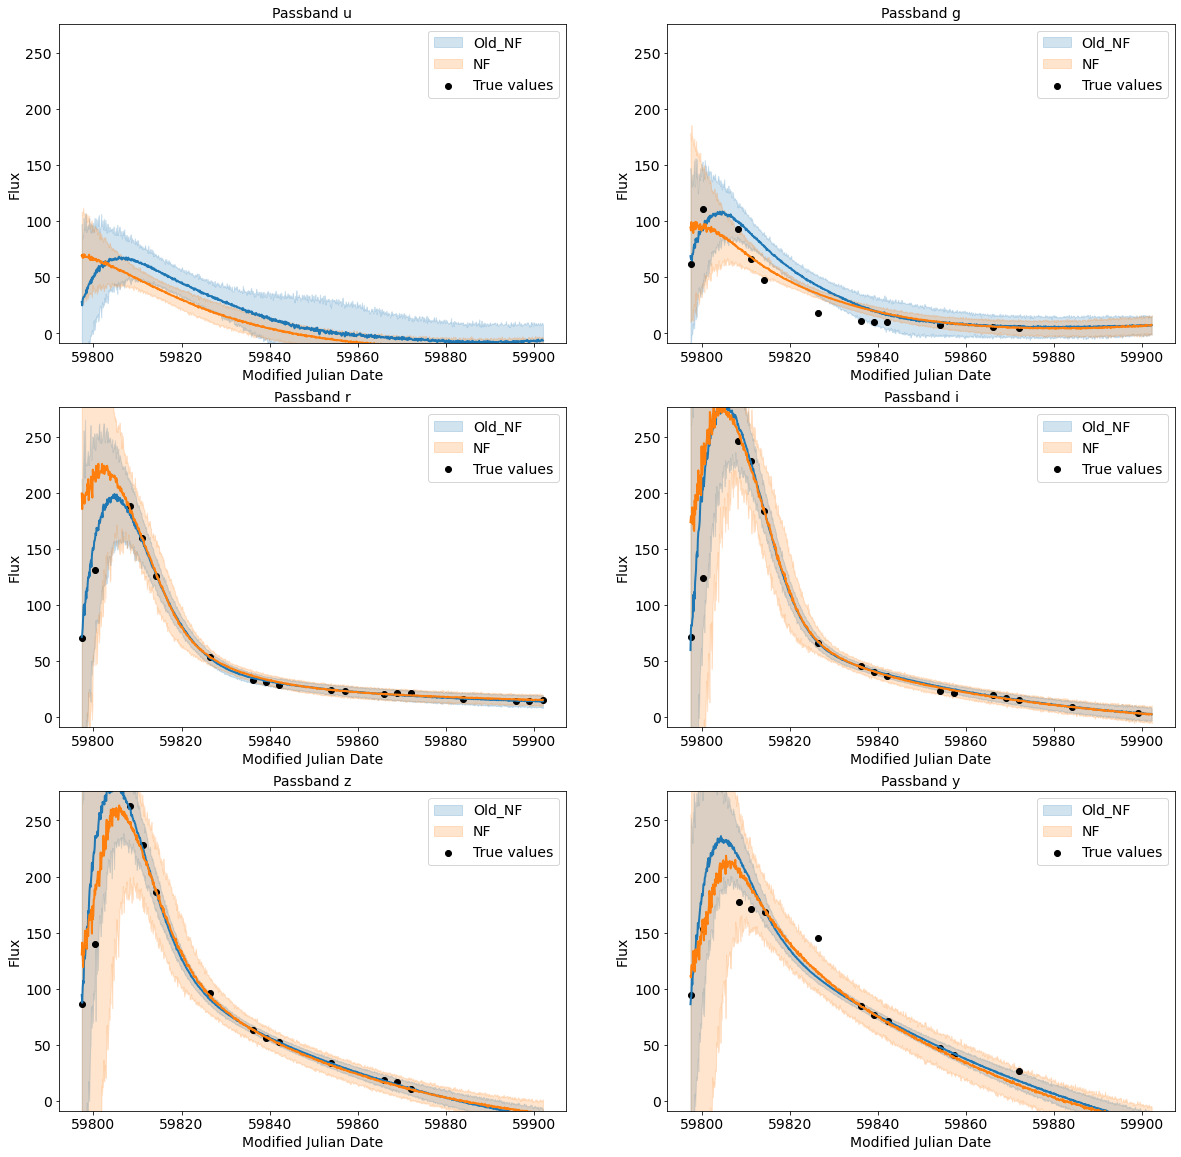

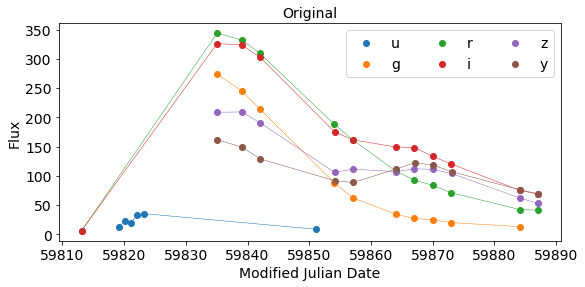

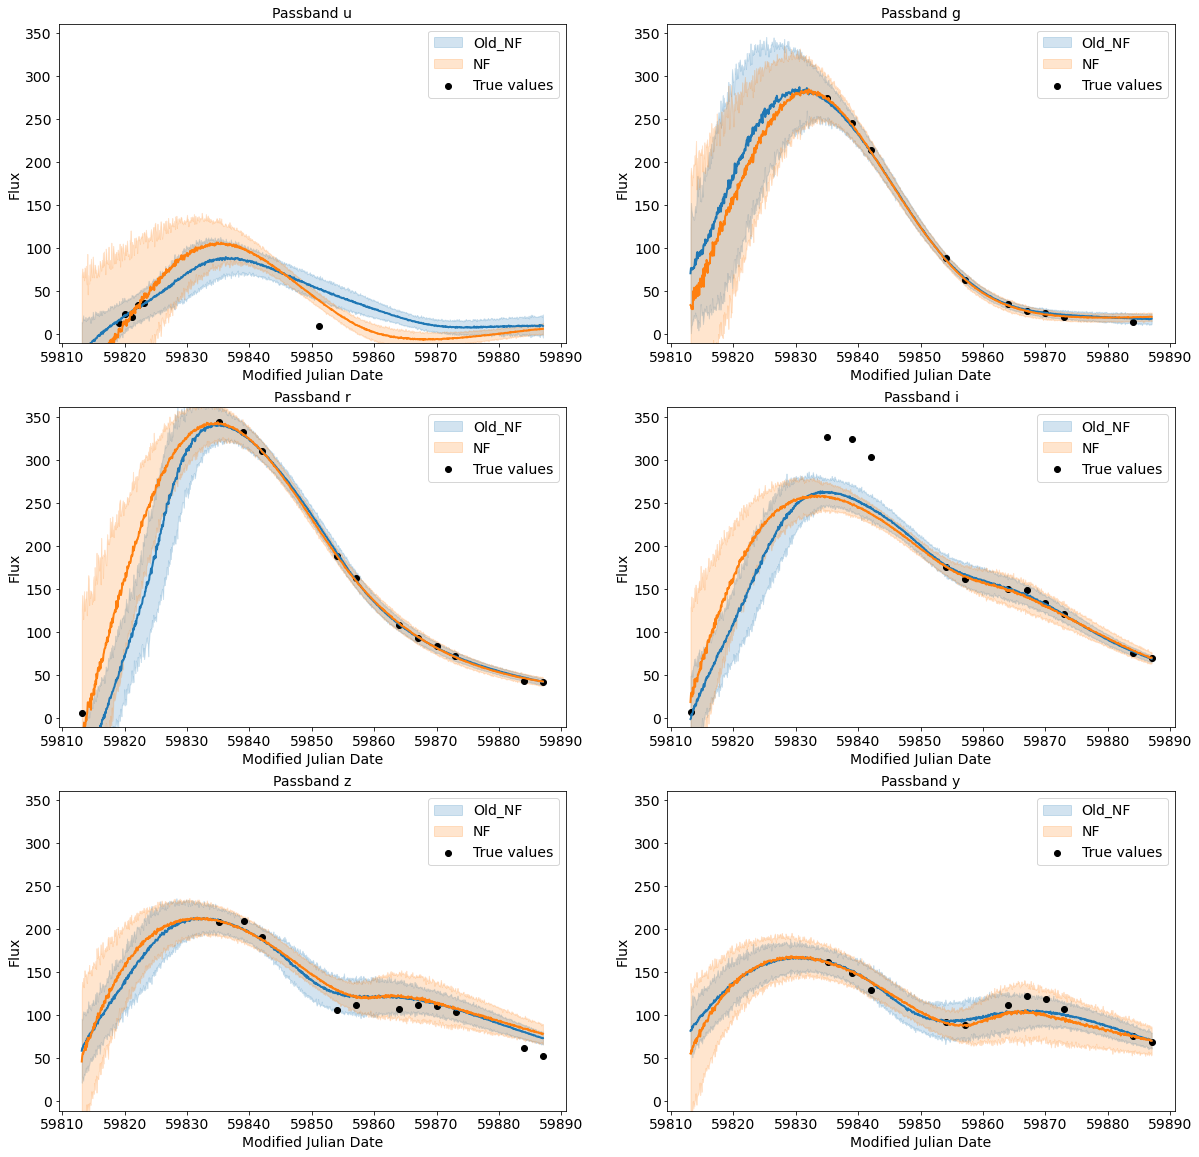

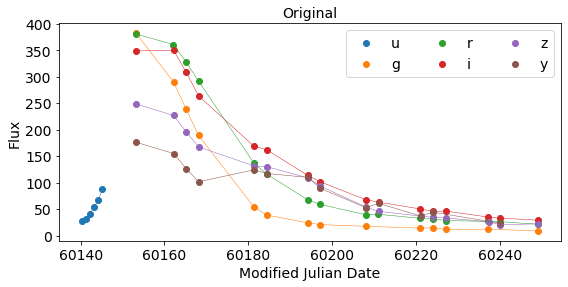

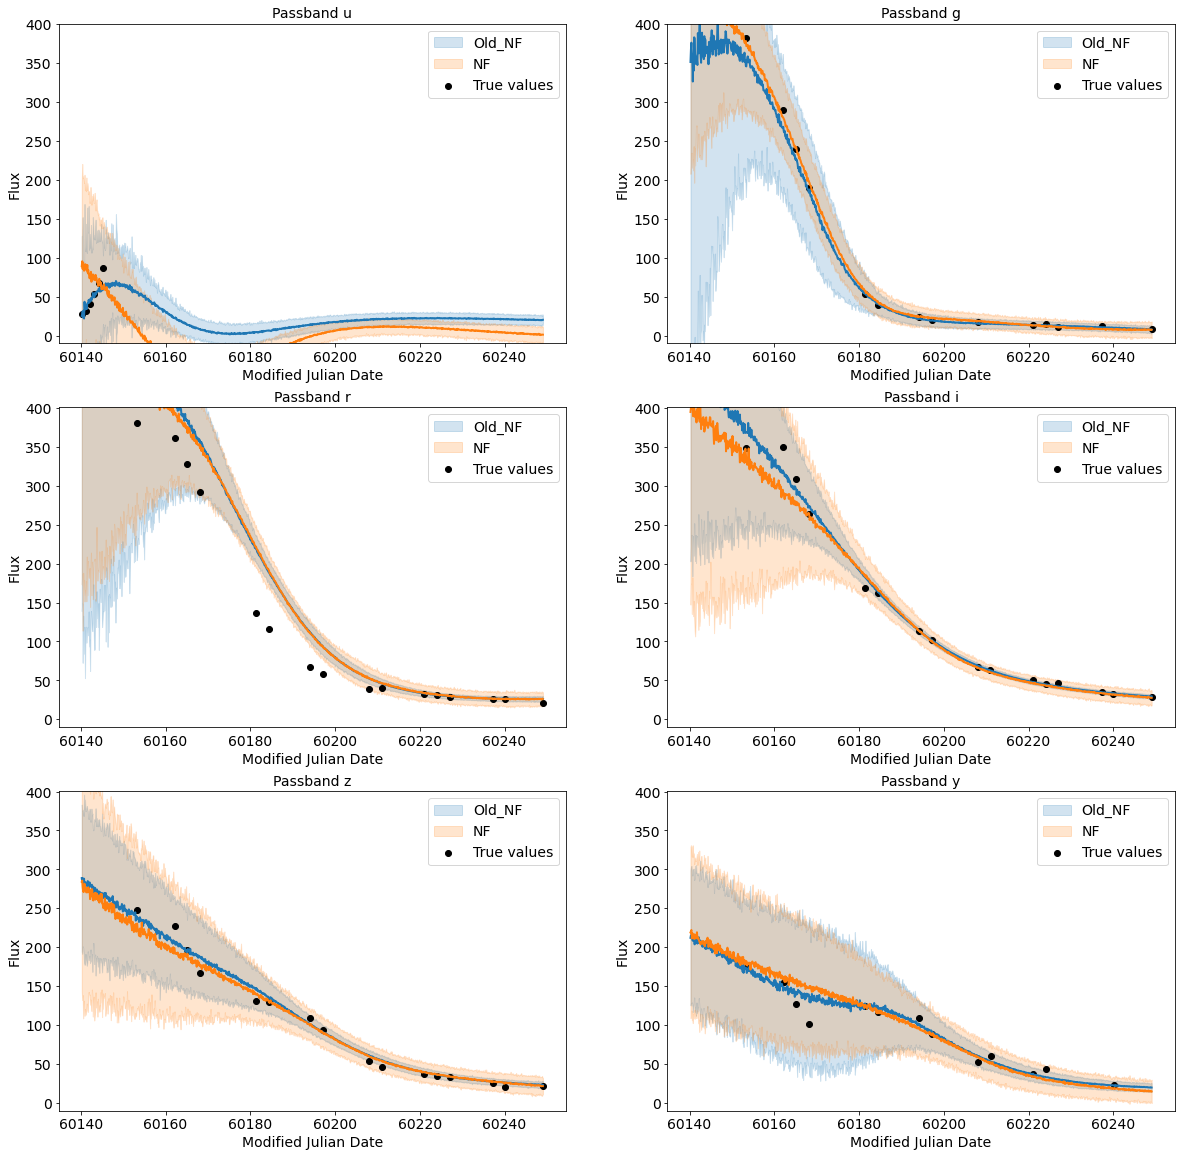

In [41]:
for i in object_ids[::42]:
    anobject = get_object(data, i)
    anobject = add_log_lam(anobject)
    
    if not is_good(anobject):
        continue
    
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)

    X_train = anobject_train[['mjd', 'log_lam']].values
    X_test = anobject_test[['mjd', 'log_lam']].values

    y_train = anobject_train['flux'].values
    y_train_std = anobject_train['flux_err'].values
    y_test  = anobject_test['flux'].values

    ss = StandardScaler()
    X_train_ss = ss.fit_transform(X_train)
    X_test_ss = ss.transform(X_test)
    
    objects = []
    
    reg = NFFitter(var_size=2, cond_size=2, normalize_y=True, batch_size=500, n_epochs=1000, lr=0.01, randomize_x=False)
    reg.fit(X_train_ss, y_train)
    approx_object = create_approx_object(anobject)
    X = approx_object[['mjd', 'log_lam']].values
    X_ss = ss.transform(X)
    approx_object['flux'], approx_object['flux_err'] = reg.predict_n_times(X_ss, n_times=100)
    objects.append(approx_object)
    
    reg = NFFitter(var_size=2, cond_size=2, normalize_y=True, batch_size=500, n_epochs=1000, lr=0.01, randomize_x=True)
    reg.fit(X_train_ss, y_train, y_train_std)
    approx_object = create_approx_object(anobject)
    X = approx_object[['mjd', 'log_lam']].values
    X_ss = ss.transform(X)
    approx_object['flux'], approx_object['flux_err'] = reg.predict_n_times(X_ss, n_times=100)
    objects.append(approx_object)
    
    plot_light_curves_compare_errors(anobject, objects, titles=['Original', 'Old_NF', 'NF'])